In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import cifar10
from vision import util


In [2]:
# Hyper-parameters
eval_iters = 200

Files already downloaded and verified
 deer   car  deer  ship   cat  deer  bird truck  bird  deer  bird   car horse   dog horse  ship truck  bird  ship   car truck   cat  frog plane horse  deer  bird   dog   car   cat   dog   dog


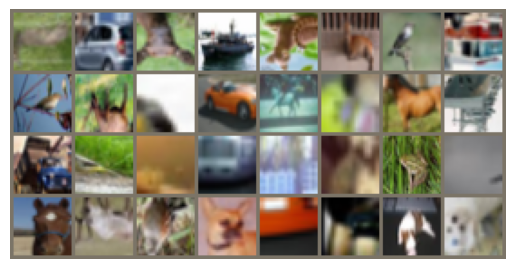

In [3]:
dataset = cifar10.CIFAR10DataSet()
downloader = dataset.train_dataloader()
images, labels = dataset.get_batch(downloader)
util.show_images(images, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in labels))

In [4]:
# Let's take one image and build the initial patch building and positional embedding step.
images.shape

torch.Size([32, 3, 32, 32])

In [5]:
# Shape of images is batch (B), channel (C), height (H), width (W)
B, C, H, W = images.shape
B, C, H, W

(32, 3, 32, 32)

## Section 3.1
The standard transformer receives as input a $1D$ sequence of token embeddings. To handle $2D$ images, we reshape the image $x \in\mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $x_p \in\mathbb{R}^{N \cdot P^2 \cdot C}$, where $(H,W)$ is the resolution of the original image, and $C$ is the number of channels, $(P,P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$

In [6]:
x_t = [torch.arange(0, 32) for _ in range(32)]
x = torch.stack(x_t, dim=-1)
kc, kh, kw = 2, 2, 2  # kernel size
dc, dh, dw = 2, 2, 2  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

torch.Size([32, 4, 2, 2, 2])


In [7]:
# https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/11
x = torch.randn(1, 500, 500, 500)  # batch, c, h, w
kc, kh, kw = 64, 64, 64  # kernel size
dc, dh, dw = 64, 64, 64  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

torch.Size([1, 343, 64, 64, 64])
tensor(True)


In [8]:
class PatchEmbedding(nn.Module):
    """
    Patch embed layer that takes a 2D image to create embed patches of size P
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_embd = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size, 
            stride=patch_size
            )
        
    def forward(self, x):
        print(f"PatchEmbedding: x.shape: {x.shape}")
        x = self.patch_embd(x)
        print(f"PatchEmbedding: patch_embd(x).shape: {x.shape}")
        x = x.flatten(2)
        print(f"PatchEmbedding: flatten(patch_embed(x)).shape: {x.shape}")
        x = x.transpose(1,2)
        print(f"PatchEmbedding: transpose(flatten(patch_embed(x)),(1,2)).shape: {x.shape}")
        return x

In [9]:
# data loading
def get_batch(dataset, split, batch_size=32):
    if split == 'train':
        downloader = dataset.train_dataloader(batch_size=batch_size)
    elif split == 'val':
        downloader = dataset.val_dataloader(batch_size=batch_size)
    elif split == 'test':
        downloader = dataset.test_dataloader(batch_size=batch_size)
    else:
        raise AttributeError(f'Invalid Split parameter ({split}) provided.')
    x, y_label = dataset.get_batch(downloader)
    y = F.one_hot(y_label, num_classes=len(dataset.get_classes()))
    return x,y.float()

x, y = get_batch(dataset, "train")
print(x.shape, y.shape)

x_val, y_val = get_batch(dataset, "val")
print(x_val.shape, y_val.shape)

x_test, y_test= get_batch(dataset, "test")
print(x_test.shape, y_test.shape)


torch.Size([32, 3, 32, 32]) torch.Size([32, 10])
torch.Size([32, 3, 32, 32]) torch.Size([32, 10])
torch.Size([32, 3, 32, 32]) torch.Size([32, 10])


truck  frog   dog   cat plane  deer  deer horse   car   car  bird   cat  deer   dog   car horse  ship horse  frog   dog truck   cat plane  frog  bird   car   dog  bird  ship   dog  frog  bird


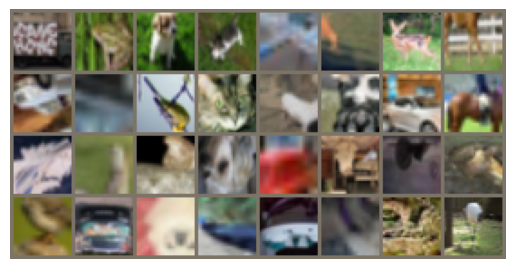

In [10]:
util.show_images(x, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y, dim=-1)))

 bird plane  frog   dog plane  ship  ship  ship   cat horse   dog horse truck horse  ship horse   cat  bird truck  ship  bird   cat  deer  ship horse plane   dog horse  ship   car   cat  deer


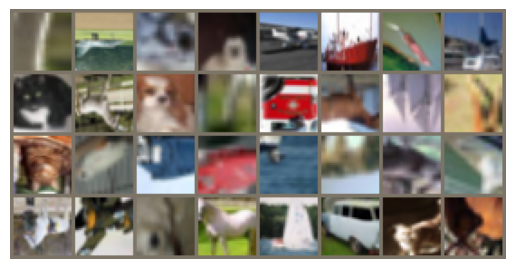

In [11]:

util.show_images(x_val, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y_val, dim=-1)))


  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


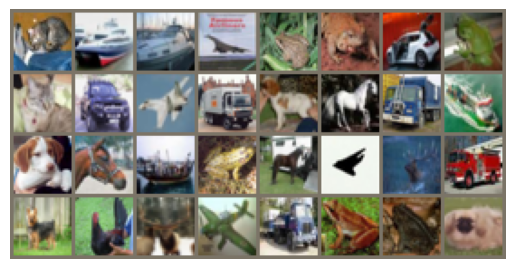

In [12]:
util.show_images(x_test, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y_test, dim=-1)))


In [13]:
class Head(nn.Module):
    """ one head of single attention """
    def __init__(self, head_size, n_embd):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5 # sqrt of head size, (B,T,C) @ (B,T,C)^T => (B,T,C) @ (B,C,T) => (B,T,T)
        wei = F.softmax(wei, dim=1) # (B,T,T)
        v = self.value(x) #(B,T,C)
        out = wei @ v # (B,T,T) @ (B,T,C) = (B,T,C)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # concat over channel dimension
        out = self.proj(out) # projection is a linear transformation of the outcome of the previous multi-head layer
        return out

In [15]:
class FeedForward(nn.Module):
    """ a simple linear layer of feedforward followed by non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer in FFwd
        )

    def forward(self, x):
        return self.nn(x)

In [16]:
class FeedForward(nn.Module):
    """ a simple linear layer of feedforward followed by non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer in FFwd
        )

    def forward(self, x):
        return self.nn(x)

In [17]:
class Block(nn.Module):
    """ Transformer Block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd : embedding dimension
        # n_head : number of heads needed for multi-head self-attention
        super().__init__()
        assert n_embd % n_head == 0, f'n_embd {n_embd}, n_head: {n_head} must be a divisor'
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd) # communication
        self.ffwd = FeedForward(n_embd) # computation
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # No residual connections
        # x = self.sa(x)
        # x = self.ffwd(x)
        # with residual connection
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))

        return x


In [18]:
class VisionTransformerModel(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=96, n_classes=10, n_layers=4, n_heads=6):
        super().__init__()
        # Every patch sequence begins with a CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.patch_embedding_table = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.position_embedding_table = nn.Embedding(self.patch_embedding_table.n_patches, embedding_dim=embed_dim)
        self.blocks = nn.Sequential(
            *[ Block(embed_dim, n_heads) for _ in range(n_layers)],
            nn.LayerNorm(embed_dim),
        )
        self.vm_head = nn.Linear(embed_dim, n_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, idx, targets=None):
        n_samples, n_chans, n_patch, _ = idx.shape
        print(f"VisionTransformerModel: n_samples={n_samples}, n_chans={n_chans}, n_patch={n_patch}")
        
        patch_emb = self.patch_embedding_table(idx)
        print(f"VisionTransformerModel: patch_emb shape={patch_emb.shape}")
        n_patches = self.patch_embedding_table.n_patches
        pos_emb = self.position_embedding_table(torch.arange(n_patches))
        print(f"VisionTransformerModel: pos_emb shape={pos_emb.shape}")
        x = patch_emb + pos_emb
        print(f"VisionTransformerModel: x (after patch+pos) shape={x.shape}")

        # Prepend the cls_token
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        print(f"VisionTransformerModel: cls_token shape={cls_token.shape}")
        x =  torch.cat((cls_token, x), dim=1)
        print(f"VisionTransformerModel: x (after cat cls_token) shape={x.shape}")

        x = self.blocks(x)
        print(f"VisionTransformerModel: x.blocks shape={x.shape}")

        cls_token_final = x[:, 0]
        print(f"VisionTransformerModel: cls_token_final shape={cls_token_final.shape}")

        logits = self.softmax(self.vm_head(cls_token_final))
        
        print(f"VisionTransformerModel: logits shape={logits.shape}")
        if targets is None:
            loss = None
        else:
            # B, T, C = logits.shape
            # print(f"VisionTransformerModel: B T C shape={B} {T} {C}")
            # logits = logits.view(B*T, C)
            # targets = targets.view(B*T)
            print(f"Logits = {logits.shape}\n{logits}\n")
            print(f"Targets = {targets.shape}\n{targets}\n")
            loss = F.cross_entropy(logits, targets)
        print(f"VisionTransformerModel: logits and loss ={logits.shape} {loss.shape}")
        return logits, loss
    


In [19]:
model = VisionTransformerModel()
x, y = get_batch(dataset, "train")
print(x.shape, y.shape)
logits, loss = model(x, y)
print(f"Logits= {logits.shape}\n", logits, f"Loss= {loss.shape}\n", loss)

torch.Size([32, 3, 32, 32]) torch.Size([32, 10])
VisionTransformerModel: n_samples=32, n_chans=3, n_patch=32
PatchEmbedding: x.shape: torch.Size([32, 3, 32, 32])
PatchEmbedding: patch_embd(x).shape: torch.Size([32, 96, 8, 8])
PatchEmbedding: flatten(patch_embed(x)).shape: torch.Size([32, 96, 64])
PatchEmbedding: transpose(flatten(patch_embed(x)),(1,2)).shape: torch.Size([32, 64, 96])
VisionTransformerModel: patch_emb shape=torch.Size([32, 64, 96])
VisionTransformerModel: pos_emb shape=torch.Size([64, 96])
VisionTransformerModel: x (after patch+pos) shape=torch.Size([32, 64, 96])
VisionTransformerModel: cls_token shape=torch.Size([32, 1, 96])
VisionTransformerModel: x (after cat cls_token) shape=torch.Size([32, 65, 96])
VisionTransformerModel: x.blocks shape=torch.Size([32, 65, 96])
VisionTransformerModel: cls_token_final shape=torch.Size([32, 96])
VisionTransformerModel: logits shape=torch.Size([32, 10])
Logits = torch.Size([32, 10])
tensor([[0.0866, 0.0894, 0.1808, 0.1272, 0.0652, 0.0

In [25]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(dataset, split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
            

In [26]:
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')


0.458314 M parameters


In [27]:
learning_rate = 3e-3
max_iters = 1000
eval_interval = 100

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch(dataset, 'train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

VisionTransformerModel: n_samples=32, n_chans=3, n_patch=32
PatchEmbedding: x.shape: torch.Size([32, 3, 32, 32])
PatchEmbedding: patch_embd(x).shape: torch.Size([32, 96, 8, 8])
PatchEmbedding: flatten(patch_embed(x)).shape: torch.Size([32, 96, 64])
PatchEmbedding: transpose(flatten(patch_embed(x)),(1,2)).shape: torch.Size([32, 64, 96])
VisionTransformerModel: patch_emb shape=torch.Size([32, 64, 96])
VisionTransformerModel: pos_emb shape=torch.Size([64, 96])
VisionTransformerModel: x (after patch+pos) shape=torch.Size([32, 64, 96])
VisionTransformerModel: cls_token shape=torch.Size([32, 1, 96])
VisionTransformerModel: x (after cat cls_token) shape=torch.Size([32, 65, 96])
VisionTransformerModel: x.blocks shape=torch.Size([32, 65, 96])
VisionTransformerModel: cls_token_final shape=torch.Size([32, 96])
VisionTransformerModel: logits shape=torch.Size([32, 10])
Logits = torch.Size([32, 10])
tensor([[0.0546, 0.1461, 0.3119, 0.0707, 0.0859, 0.1003, 0.0303, 0.0920, 0.0891,
         0.0191],
  